In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import numpy as np
from option import Option, OptionType
def optimal_price(option: Option, V, eps=1e-6):
    S_min, S_max = np.min(V.x), np.max(V.x)
    if option.type == OptionType.CALL:
        S_axis = np.linspace(option.K, S_max, num=10000)
        idx = np.argmax( np.abs(V(S_axis[1:]) - option.payoff(S_axis[1:])) < eps )
        return S_axis[idx]
    elif option.type == OptionType.PUT:
        S_axis = np.linspace(S_min, option.K, num=10000)
        idx = np.argmin( np.abs(V(S_axis) - option.payoff(S_axis)) < eps ) - 1
        return S_axis[idx]


# Test case 1: American call options without dividends

## Setup

In [3]:
import numpy as np
import pandas as pd
import option
import utils

K = 1
T = 1
call = option.call(K, T)
r = 0.1
sigma = 0.2
delta = 0
S_max = 2
S_test = np.arange(0.8, S_max + 0.1, step=0.2)

In [4]:
import matplotlib.pyplot as plt
V_bopm = np.array([utils.calculate_amer_option(call, si, r, sigma, 1000, delta=delta) for si in S_test])

S_bar 1.0


(-0.01, 0.5)

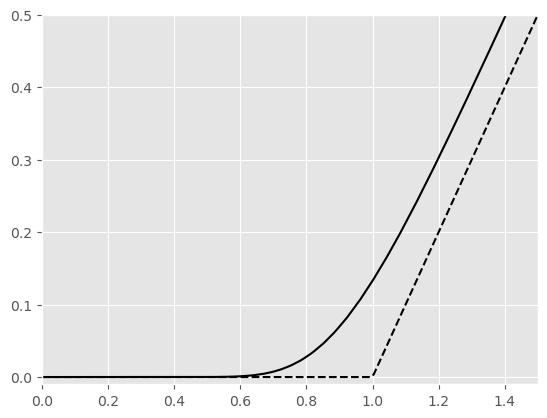

In [5]:
from scipy import interpolate

S_plot = np.linspace(0, 3, num=300)
V_plot = np.array([utils.calculate_amer_option(call, si, r, sigma, 100, delta=delta) for si in S_plot])

S_foo = np.linspace(K, 3, num=1000)
V_foo = interpolate.interp1d(S_plot, V_plot)
print("S_bar", S_foo[np.argmax(np.abs(V_foo(S_foo) - call.payoff(S_foo)) <= 0.00001)])

plt.plot(S_plot, V_plot, '-k')
plt.plot(S_plot, call.payoff(S_plot), '--k')
plt.xlim([0, 1.5])
plt.ylim(bottom=-0.01, top=0.5)

## Nielsen transformation

### Explicit

S_bar 2.1234495441742784
        0.125    0.0625   0.03125  0.015625  0.0078125      BOPM
0.8  0.002621 -0.010625 -0.013524 -0.002015  -0.000001  0.027907
1.0  0.004706  0.013893  0.013002 -0.029306   0.000891  0.132688
1.2  0.014161  0.200000  0.200000  0.055699   0.025872  0.302596
1.4  0.037339  0.400000  0.400000  0.368943   0.159235  0.496317
1.6  0.060518  0.600000  0.600000  0.600000   0.428869  0.695316
1.8  0.131259  0.800000  0.800000  0.800000   0.733696  0.895181
2.0  0.245200  1.000000  1.000000  1.000000   0.991996  1.095165


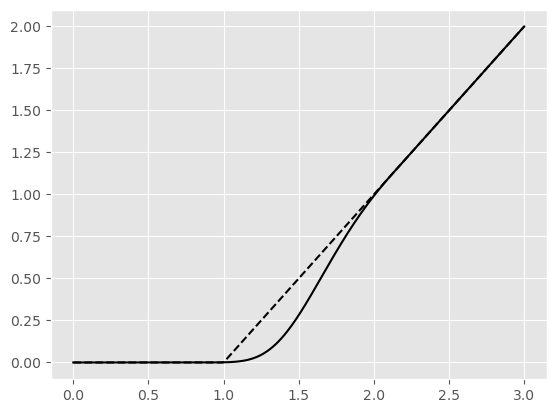

In [6]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V_call, S_bar = nielsen.solve_explicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta)
    V_call = utils.interpolate_call_amer(call, S_bar, 5, S, V_call)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 3, num=300)  
        plt.plot(S_plot, V_call(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        print("S_bar", S_bar)
    V_pred[i] = V_call(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [7]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

0.125        0.537170
0.0625       0.094567
0.03125      0.094902
0.015625     0.137072
0.0078125    0.212490
dtype: float64

### Implicit

S_bar 38241.90143753404
        0.125    0.0625   0.03125      0.015625  0.0078125      BOPM
0.8  0.000000  0.000000 -0.205959 -1.604973e+05   0.795922  0.027907
1.0  0.004449  0.005186  0.003192 -3.575623e+05   0.994903  0.132688
1.2  0.200000  0.200000  0.200000  1.721827e+05   1.193883  0.302596
1.4  0.400000  0.400000  0.400000 -3.568104e+05   1.392864  0.496317
1.6  0.600000  0.600000  0.600000  1.219693e+06   1.591844  0.695316
1.8  0.800000  0.800000  0.800000 -6.259446e+05   1.790825  0.895181
2.0  1.000000  1.000000  1.000000 -4.666436e+05   1.989806  1.095165


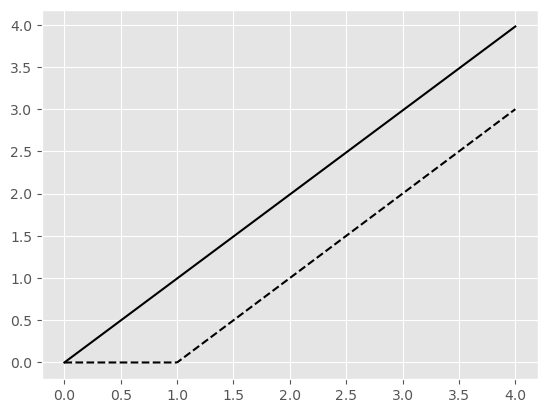

In [8]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = [1/8, 1/16, 1/32, 1/64, 1/128]

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    put = option.put(K, T)
    S, V, S_bar = nielsen.solve_implicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0.2, x_max=3)
    V = utils.interpolate_call_amer(call, S_bar, 5, S, V)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 4, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        print("S_bar", S_bar)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

## Company transformation

### Explicit

S_bar 0.27948496518390537
         0.25    0.125    0.0625   0.03125  0.015625  0.0078125      BOPM
0.8  0.000000  0.00000  0.000000  0.000000  0.000062   0.000000  0.027907
1.0  0.002145  0.00481  0.007385  0.002932 -0.069365   0.005883  0.132688
1.2  0.200000  0.20000  0.200000  0.200000  0.196188   0.200000  0.302596
1.4  0.400000  0.40000  0.400000  0.400000  0.400000   0.400000  0.496317
1.6  0.600000  0.60000  0.600000  0.600000  0.600000   0.600000  0.695316
1.8  0.800000  0.80000  0.800000  0.800000  0.800000   0.800000  0.895181
2.0  1.000000  1.00000  1.000000  1.000000  1.000000   1.000000  1.095165


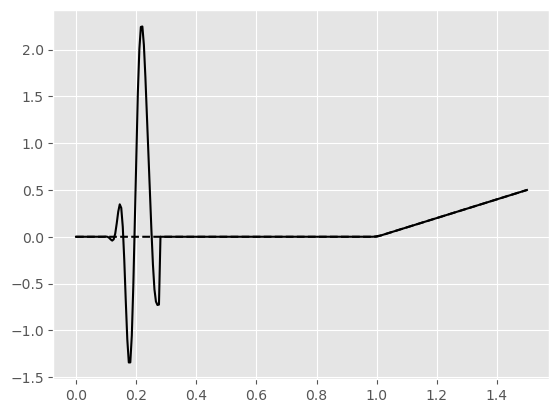

In [9]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen, company
from scipy import interpolate
import timeit

dx = [1/4, 1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V, S_bar = company.solve_explicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, x_min=-3)
    S = np.append([0], S)
    V = np.append([0], V)
    V = utils.interpolate_call_amer(call, S_bar, 5, S, V)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        print("S_bar", S_bar)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [10]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

0.25         0.096232
0.125        0.095719
0.0625       0.095232
0.03125      0.096080
0.015625     0.113012
0.0078125    0.095515
dtype: float64

## LCP

### Explicit

S_bar 1.0
S_bar 1.0
S_bar 1.0
S_bar 1.0
         0.25     0.125    0.0625   0.03125      BOPM
0.8  0.035986  0.030397  0.028677  0.028005  0.027907
1.0  0.125586  0.131194  0.132382  0.132621  0.132688
1.2  0.311949  0.304792  0.302906  0.302686  0.302596
1.4  0.506524  0.498959  0.496966  0.496474  0.496317
1.6  0.707048  0.698232  0.696046  0.695494  0.695316
1.8  0.908359  0.898438  0.895992  0.895384  0.895181
2.0  1.109923  1.098800  1.096070  1.095391  1.095165
[0.009704351425170898, 0.0803985595703125, 0.6118729114532471, 4.870193243026733]


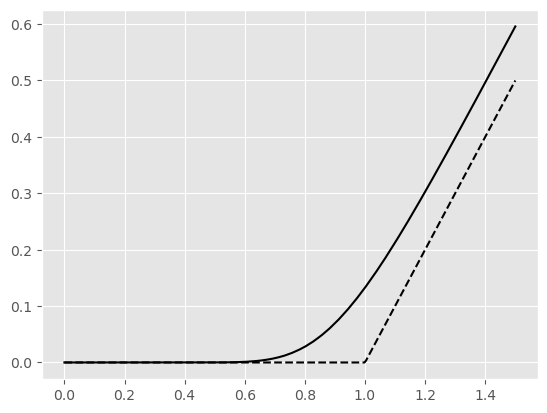

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcp
from scipy import interpolate
import time

dx = [1/4, 1/8, 1/16, 1/32]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=0)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(call, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [12]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

0.25       0.010931
0.125      0.002740
0.0625     0.000678
0.03125    0.000156
dtype: float64

### Implicit

         0.25     0.125    0.0625   0.03125      BOPM
0.8  0.041190  0.032857  0.029850  0.028580  0.027907
1.0  0.128311  0.132033  0.132878  0.132870  0.132688
1.2  0.316927  0.306862  0.303863  0.303147  0.302596
1.4  0.513035  0.501775  0.498305  0.497128  0.496317
1.6  0.714570  0.701480  0.697585  0.696247  0.695316
1.8  0.916898  0.902104  0.897722  0.896228  0.895181
2.0  1.119481  1.102900  1.098003  1.096334  1.095165
[0.01624321937561035, 0.0777897834777832, 0.39196085929870605, 2.0429415702819824]


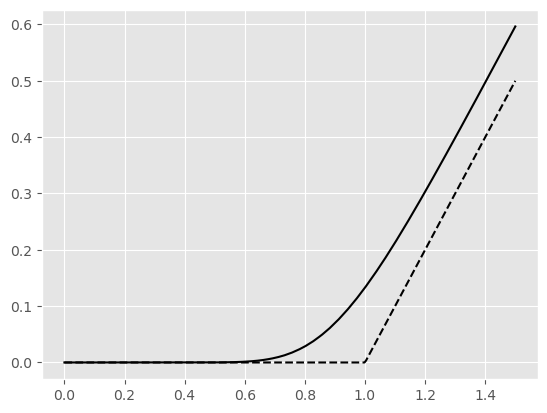

In [13]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
import lcp
from scipy import interpolate
import timeit

dx = [1/4, 1/8, 1/16, 1/32]
dt = [1/4, 1/8, 1/16, 1/32]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=1)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [14]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.25       0.017379
0.125      0.005589
0.0625     0.002037
0.03125    0.000826
dtype: float64

### Crank-Nicholson

         0.25     0.125    0.0625   0.03125      BOPM
0.8  0.036521  0.030514  0.028705  0.028011  0.027907
1.0  0.125948  0.131290  0.132405  0.132626  0.132688
1.2  0.312525  0.304918  0.302937  0.302694  0.302596
1.4  0.507260  0.499129  0.497007  0.496484  0.496317
1.6  0.707907  0.698431  0.696095  0.695507  0.695316
1.8  0.909335  0.898664  0.896048  0.895398  0.895181
2.0  1.111015  1.099052  1.096132  1.095406  1.095165
[0.01277470588684082, 0.058762550354003906, 0.26402926445007324, 1.3389933109283447]


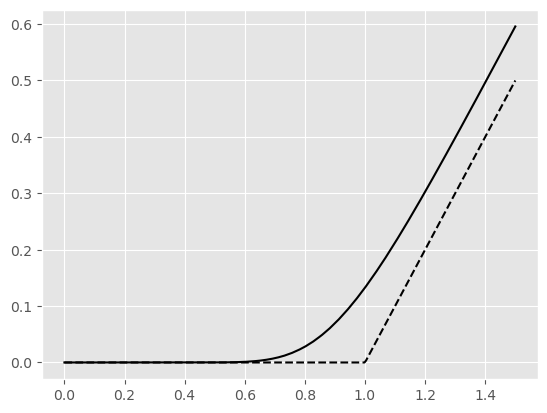

In [15]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
import lcp
from scipy import interpolate
import timeit

dx = [1/4, 1/8, 1/16, 1/32]
dt = [1/4, 1/8, 1/16, 1/32]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=0.5)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [16]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.25       0.011638
0.125      0.002903
0.0625     0.000717
0.03125    0.000166
dtype: float64

# Test case 2: American put options without dividends

## Setup

In [17]:
import numpy as np
import pandas as pd
import option
import utils
from scipy import interpolate

K = 1
T = 1
put = option.put(K, T)
r = 0.1
sigma = 0.2
S_max = 1.6
S_test = np.arange(0.8, S_max + 0.2, step=0.2)

In [18]:
import matplotlib.pyplot as plt
V_bopm = np.array([utils.calculate_amer_option(put, si, r, sigma, 1000) for si in S_test])

S_bar 1.5


(-0.01, 0.2)

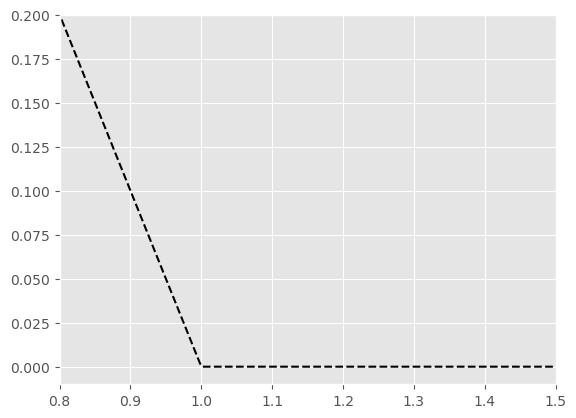

In [19]:
S_plot = np.linspace(0, 1.5, num=500)
V_plot = np.array([utils.calculate_amer_option(put, si, r, sigma, 50) for si in S_plot])

S_foo = np.linspace(0, 1.5, num=1000)
V_foo = interpolate.interp1d(S_plot, V_plot)
print("S_bar", S_foo[np.argmin(np.abs(V_foo(S_foo) - put.payoff(S_foo)) <= 0.00001)-1])

plt.plot(S_plot, V_plot, '-k')
plt.plot(S_plot, put.payoff(S_plot), '--k')
plt.xlim([0.8, 1.5])
plt.ylim(bottom=-0.01,top=0.2)

## Nielsen transformation

### Explicit

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import time

dx = np.array([1/128])
dt = 2*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V, S_bar = nielsen.solve_explicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, x_max=2)
    end = time.time()
    cpu_time.append(end - start)
    V = utils.interpolate_put_amer(put, S_bar, S, V)
    V_pred[i] = V(S_test)
    if i == len(dx)-1:
        plt.plot(np.linspace(0, 1.5, num=300), V(np.linspace(0, 1.5, num=300)), '-k')
        plt.plot(np.linspace(0, 1.5, num=300), put.payoff(np.linspace(0, 1.5, num=300)), '--k')
        plt.xlim([0.5, 1.5])
        plt.ylim(top=0.5)
        print("S_bar", S_bar)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

### Implicit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = [1/8, 1/16, 1/32, 1/64, 1/128]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V_call, S_bar = nielsen.solve_implicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, x_max=3)
    end = time.time()
    cpu_time.append(end - start)
    V = utils.interpolate_put_amer(put, S_bar, S, V_call)
    V_pred[i] = V(S_test)
    if i == len(dx)-1:
        plt.plot(np.linspace(0, 1.5, num=300), V(np.linspace(0, 1.5, num=300)), '-k')
        plt.plot(np.linspace(0, 1.5, num=300), put.payoff(np.linspace(0, 1.5, num=300)), '--k')
        plt.xlim([0.5, 1.5])
        plt.ylim(top=0.5)
        print("S_bar: ", S_bar)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [ ]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

## Company transformation

### Explicit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import company
from scipy import interpolate
import time

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V, S_bar = company.solve_explicitly(put, r=r,sigma=sigma, dx=dx[i], dt
    =dt[i], delta=0, x_max=3)
    end = time.time()
    cpu_time.append(end - start)
    V = utils.interpolate_put_amer(put, S_bar, S, V)
    V_pred[i] = V(S_test)
    if i == len(dx)-1:
        S_p = np.linspace(0, 1.5, num=300)
        print("S_bar", S_bar)
        plt.plot(S_p, V(S_p), '-k')
        plt.plot(S_p, put.payoff(S_p), '--k')
        plt.xlim([0.5, 1.5])
        plt.ylim(top=0.5)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [ ]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

## LCP

### Explicit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcp
from scipy import interpolate
import time

dx = [1/4, 1/8, 1/16, 1/32]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, theta=0)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(put, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, put.payoff(S_plot), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(bottom=-0.01,top=0.2)
        print("S_bar", optimal_price(put, V))
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [ ]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

### Implicit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcp
from scipy import interpolate
import time

dx = [1/4, 1/8, 1/16, 1/32]
dt = dt[:]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, theta=1)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(put, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, put.payoff(S_plot), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(bottom=-0.01,top=0.2)
        print("S_bar", optimal_price(put, V))
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [ ]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

### Crank-Nicholson

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcp
from scipy import interpolate
import time

dx = [1/4, 1/8, 1/16, 1/32]
dt = dt[:]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, theta=0.5)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(put, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, put.payoff(S_plot), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(bottom=-0.01,top=0.2)
        print("S_bar", optimal_price(put, V))
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [ ]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

# Test case 3: American call options with dividends

## Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import option
import utils

K = 1
T = 1
call = option.call(K, T)
r = 0.1
sigma = 0.2
delta = 0.09
S_max = 2
S_min = 0
S_test = np.arange(S_min, S_max, step=0.2)

In [ ]:
from scipy import interpolate
S_plot = np.linspace(S_min, S_max, num=100)
V_plot = np.array([utils.calculate_amer_option(call, si, r, sigma, 100, delta=delta) for si in S_plot])

S_foo = np.linspace(K, S_max, num=1000)
V_foo = interpolate.interp1d(S_plot, V_plot, kind='cubic')
print("S_bar", S_foo[np.argmax(np.abs(V_foo(S_foo) - call.payoff(S_foo)) <= 0.00001)])

In [ ]:
plt.plot(S_plot, V_plot, '-k')
payoff_linspace = np.linspace(0, S_max, num=500)
plt.plot(payoff_linspace, call.payoff(payoff_linspace), '--k')
plt.xlim(left=0.5,right=1.4)
plt.ylim(bottom=-0.01, top=0.4)

In [ ]:
import matplotlib.pyplot as plt
V_bopm = np.array([utils.calculate_amer_option(call, si, r, sigma, 1000, delta=delta) for si in S_test])
V_bopm

## Nielsen transformation

### Explicit

In [ ]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V, S_bar = nielsen.solve_explicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta)
    V = utils.interpolate_call_amer(call, S_bar, S_max+2, S, V)
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=100)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(payoff_linspace, call.payoff(payoff_linspace), '--k')
        print("S_bar", S_bar)
        # plt.xlim(left=0.7,right=1.1)
        # plt.ylim(top=0.1, bottom=-0.01)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [ ]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

### Implicit

In [ ]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/4]#[1/8, 1/16, 1/32, 1/64, 1/128]
dt = [1/4]#[1/8, 1/16, 1/32, 1/64, 1/128]

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    put = option.put(K, T)
    S, V_call, S_bar = nielsen.solve_implicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0.2, x_max=3)
    plt.plot(S, V_call)
    plt.plot(np.linspace(0, 2.5, num=300) , call.payoff(np.linspace(0, 2.5, num=300)))
#     V_put = utils.interpolate_call_amer(call, S_bar, 5, S, V_put)
#     if i == len(dx)-1:
#         S_plot = np.linspace(0, 2.5, num=300)  
#         plt.plot(S_plot, V_put(S_plot), '-k')
#         plt.plot(S_plot, call.payoff(S_plot), '--k')
#         print("S_bar", S_bar)
#     V_pred[i] = V_put(S_test)
# table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
# table.loc['BSF'] = V_bopm[:]
# print(table.T)

## Company transformation

### Explicit

In [ ]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen, company
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V, S_bar = company.solve_explicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, x_min=-3)
    S = np.append([0], S)
    V = np.append([0], V)
    V = utils.interpolate_call_amer(call, S_bar, S_max+5, S, V)
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        print("S_bar", S_bar)
        plt.xlim(left=0.7,right=1.1)
        plt.ylim(top=0.1, bottom=-0.01)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [ ]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

## LCP

### Explicit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp
import time

dx = [1/8, 1/16, 1/32]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=0)
    end = time.time()
    cpu_time.append(end-start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(call, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        plt.xlim(left=0.5,right=1.4)
        plt.ylim(bottom=-0.01, top=0.4)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [ ]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

### Implicit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp
import time

dx = [1/8, 1/16, 1/32]
dt = dt[:]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=1)
    end = time.time()
    cpu_time.append(end-start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(call, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        plt.xlim(left=0.5,right=1.4)
        plt.ylim(bottom=-0.01, top=0.4)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [ ]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

### Crank-Nicholson

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp
import time

dx = [1/8, 1/16, 1/32]
dt = dt[:]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=0.5)
    end = time.time()
    cpu_time.append(end-start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(call, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        plt.xlim(left=0.5,right=1.4)
        plt.ylim(bottom=-0.01, top=0.4)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [ ]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

# Test case 4: American put options with dividends

## Setup

In [ ]:
import numpy as np
import pandas as pd
import option
import utils
from scipy import interpolate
import matplotlib.pyplot as plt
K = 1
T = 1
put = option.put(K, T)
r = 0.1
sigma = 0.2
delta=0.03
S_max = 1.5
dx = 0.2
S_test = np.arange(0, S_max + dx, step=dx)

In [ ]:
S_plot = np.linspace(0, 1.5, num=300)
V_plot = np.array([utils.calculate_amer_option(put, si, r, sigma, 100, delta=delta) for si in S_plot])
S_foo = np.linspace(0, 1.5, num=100)
V_foo = interpolate.interp1d(S_plot, V_plot)
print("S_bar", S_foo[np.argmin(np.abs(V_foo(S_foo) - put.payoff(S_foo)) <= 0.00001)-1])

plt.plot(S_plot, V_plot, '-k')
plt.plot(S_plot, put.payoff(S_plot), '--k')
plt.xlim([0.8, 1.5])
plt.ylim(top=0.2, bottom=-0.01)

In [ ]:
import matplotlib.pyplot as plt
V_bopm = np.array([utils.calculate_amer_option(put, si, r, sigma, 100, delta=delta) for si in S_test])
V_bopm

## Nielsen transformation

### Explicit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import time

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V_put, S_bar = nielsen.solve_explicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, x_max=3)
    end = time.time()
    cpu_time.append(end - start)
    V_put = utils.interpolate_put_amer(put, S_bar, S, V_put)
    if i == len(dx)-1:
        S_foo = np.linspace(0, 2.5, num=300)
        plt.plot(S_foo, V_put(S_foo), '-k')
        plt.plot(S_foo, put.payoff(S_foo), '--k')
        print("S_bar", S_bar)
        plt.xlim([0.8, 1.5])
        plt.ylim(top=0.2, bottom=-0.01)
    V_pred[i] = V_put(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(np.array(cpu_time))

In [ ]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5).values
# (V_bsf - table.loc[dx])

### Implicit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = [1/8, 1/16, 1/32, 1/64, 1/128]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V_call, S_bar = nielsen.solve_implicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, x_max=3)
    end = time.time()
    cpu_time.append(end - start)
    V_put = utils.interpolate_put_amer(put, S_bar, S, V_call)
    V_pred[i] = V_put(S_test)
    if i == len(dx)-1:
        S_foo = np.linspace(0, 2.5, num=300)
        plt.plot(S_foo, V_put(S_foo), '-k')
        plt.plot(S_foo, put.payoff(S_foo), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(top=0.2, bottom=-0.01)
        print("S_bar: ", S_bar)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(np.array(cpu_time))

In [ ]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5).values

## Company transformation

### Explicit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import time

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V_put, S_bar = company.solve_explicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, x_max=3)
    end = time.time()
    cpu_time.append(end - start)
    V_put = utils.interpolate_put_amer(put, S_bar, S, V_put)
    if i == len(dx)-1:
        S_foo = np.linspace(0, 2.5, num=300)
        plt.plot(S_foo, V_put(S_foo), '-k')
        plt.plot(S_foo, put.payoff(S_foo), '--k')
        print("S_bar", S_bar)
        plt.xlim([0.8, 1.5])
        plt.ylim(top=0.2, bottom=-0.01)
    V_pred[i] = V_put(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(np.array(cpu_time))

In [ ]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5).values

## LCP

### Explicit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp
import time

dx = [1/8, 1/16, 1/32]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=0)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(put, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, put.payoff(S_plot), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(top=0.2, bottom=-0.01)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [ ]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

### Implicit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp
import time

dx = [1/8, 1/16, 1/32]
dt = dx[:]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=1)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(put, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, put.payoff(S_plot), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(top=0.2, bottom=-0.01)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [ ]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

### Crank-Nicholson

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp
import time

dx = [1/8, 1/16, 1/32]
dt = dx[:]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=0.5)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(put, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, put.payoff(S_plot), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(top=0.2, bottom=-0.01)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [ ]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)